# Tutorial 3 - Trajectory data mining in Python

```{attention}
Finnish university students are encouraged to use the CSC Notebooks platform.<br/>
<a href="https://notebooks.csc.fi/#/blueprint/c54303e865294208ba1ef381332fd69b"><img alt="CSC badge" src="https://img.shields.io/badge/launch-CSC%20notebook-blue.svg" style="vertical-align:text-bottom"></a>

Others can follow the lesson interactively using Binder. Check the rocket icon on the top of this page.
```

In this tutorial, we will learn how to conduct exploratory space-time data analysis (ESTDA) based on movement data. When analyzing mobility data, using various visualization approaches (visual analytics) is important to be able to understand the data and extract insights from it. Here, we will learn a few tricks how we can manipulate movement data and visualize it using static and interactive visualizations in Python. 

```{admonition} Attribution

This tutorial is partly based on excellent resources provided by Anita Graser and the documentation of `movingpandas` [library](https://github.com/anitagraser/movingpandas).

```

In [29]:
import pandas as pd
from keplergl import KeplerGl
import geopandas as gpd
import movingpandas as mpd
from datetime import datetime, timedelta
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

## Input data

In this tutorial, we will use AIS data that describes vessel movements ([obtained from movingpandas](https://github.com/anitagraser/movingpandas-examples/tree/main/data)). The AIS data has been published by the Danish Maritime Authority. The AIS record sample extracted for this tutorial covers vessel traffic on the 5th July 2017 near Gothenburg. Let's start by reading it and checking how the data looks like: 

<AxesSubplot:>

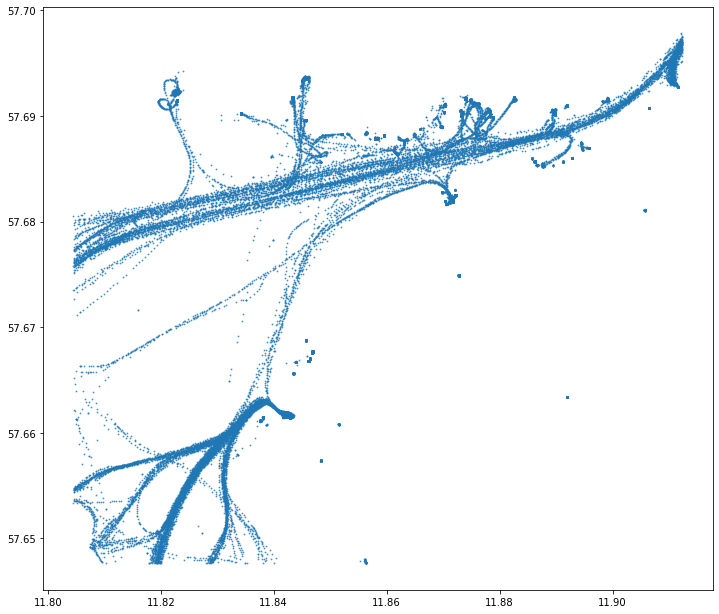

In [2]:
# Filepath
fp = "data/ais.gpkg"
data = gpd.read_file(fp);
data.plot(figsize=(12,12), markersize=0.7, alpha=0.7)

In [3]:
data.shape

(84702, 8)

In [4]:
# Check first rows
data.head()

Timestamp       MMSI               NavStatus  SOG    COG  Name  \
0  05/07/2017 00:00:03  219632000  Under way using engine  0.0  270.4  None   
1  05/07/2017 00:00:05  265650970  Under way using engine  0.0    0.5  None   
2  05/07/2017 00:00:06  265503900  Under way using engine  0.0    0.0  None   
3  05/07/2017 00:00:14  219632000  Under way using engine  0.0  188.4  None   
4  05/07/2017 00:00:19  265519650  Under way using engine  0.0  357.2  None   

    ShipType                   geometry  
0  Undefined  POINT (11.85958 57.68817)  
1  Undefined  POINT (11.84175 57.66150)  
2  Undefined  POINT (11.90650 57.69077)  
3  Undefined  POINT (11.85958 57.68817)  
4  Undefined  POINT (11.87192 57.68233)

Okay as we can see, we have around 80,000 recorded observations and information about the timestamp, geometry, ship type etc. `SOG` column contains information about speed over ground. Let's take a look at the data distribution:

<AxesSubplot:>

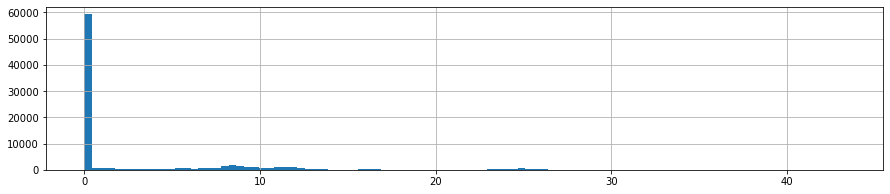

In [5]:
data['SOG'].hist(bins=100, figsize=(15,3))

As we can see, most of the observations are actually such where the vessels have not been moving, i.e. they are staying at the harbor. It is not useful to keep such records in our data, so let's get rid off those: 

In [6]:
data = data[data.SOG>0].copy()
data.shape

(33593, 8)

Okay, now we have much less observations. Let's at this point calculate `x` and `y` coordinates based on our Point geometries, so that we can easily plot our data in 3D:

In [7]:
# Calculate x and y coordinates
data["x"] = data["geometry"].x
data["y"] = data["geometry"].y
data.head()

Timestamp       MMSI               NavStatus  SOG    COG  \
6   05/07/2017 00:00:28  265647200                  Moored  0.1  298.0   
7   05/07/2017 00:00:31  265663280  Under way using engine  0.1  131.6   
22  05/07/2017 00:01:03  219632000  Under way using engine  0.1  233.9   
32  05/07/2017 00:01:30  265663280  Under way using engine  0.1  348.6   
85  05/07/2017 00:03:35  376474000  Under way using engine  8.8  229.2   

       Name   ShipType                   geometry          x          y  
6      None  Undefined  POINT (11.89120 57.68569)  11.891205  57.685688  
7      None  Undefined  POINT (11.87037 57.68194)  11.870370  57.681937  
22     None  Undefined  POINT (11.85958 57.68817)  11.859583  57.688167  
32     None  Undefined  POINT (11.87037 57.68194)  11.870368  57.681942  
85  LARGONA      Cargo  POINT (11.91198 57.69591)  11.911977  57.695910

## Constructing trajectories

Next, we want to convert our individual point observations into **trajectories**. This can be done easily using the ``TrajectoryCollection`` functionality / class provided by movingpandas (see [docs](https://movingpandas.readthedocs.io/en/master/trajectorycollection.html)). To be able to use this functionality, we first need to parse a ``DateTime`` index based on the ``Timestamp`` column, and that the `MMSI` number (*Maritime Mobile Service Idenity*) is used as the unique id for a ship. We also specify that the minimum length for a trajectory needs to be at least 100 meters:

In [8]:
# Create trajectories
data['time'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M:%S')
data = data.set_index('time')

# Specify minimum length for a trajectory (in meters)
minimum_length = 100 
collection = mpd.TrajectoryCollection(data, 'MMSI', min_length=minimum_length)

# What did we get?
collection

TrajectoryCollection with 77 trajectories

As a result, we get an object that represents the collection of trajectories identified by movingpandas. We can plot all the trajectories easily by:

<AxesSubplot:>

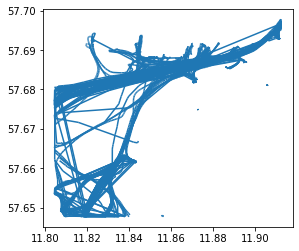

In [9]:
# Plot all trajectories
collection.plot()

We can access each of these trajectories individually by looping over our collection. We can also easily calculate the speed and add information about the direction of movement to our data by:

In [10]:
for trajectory in collection.trajectories:
    # Calculate speed
    trajectory.add_speed(overwrite=True)
    
    # Determine direction of movement
    trajectory.add_direction(overwrite=True)
    
    # Let's first check only the first trajectory (i.e. stop iteration after first run)
    break

Let's see what we got. We can access the DataFrame of the given trajectory by:

In [11]:
trajectory.df.head()

Timestamp       MMSI               NavStatus  \
time                                                                          
2017-07-05 17:32:18  05/07/2017 17:32:18  210035000  Under way using engine   
2017-07-05 17:32:28  05/07/2017 17:32:28  210035000  Under way using engine   
2017-07-05 17:32:36  05/07/2017 17:32:36  210035000  Under way using engine   
2017-07-05 17:32:38  05/07/2017 17:32:38  210035000  Under way using engine   
2017-07-05 17:32:48  05/07/2017 17:32:48  210035000  Under way using engine   

                     SOG   COG            Name ShipType  \
time                                                      
2017-07-05 17:32:18  9.8  52.8  NORDIC HAMBURG    Cargo   
2017-07-05 17:32:28  9.8  51.0  NORDIC HAMBURG    Cargo   
2017-07-05 17:32:36  9.8  51.0  NORDIC HAMBURG    Cargo   
2017-07-05 17:32:38  9.8  51.0  NORDIC HAMBURG    Cargo   
2017-07-05 17:32:48  9.7  52.0  NORDIC HAMBURG    Cargo   

                                      geometry          x          y  \
time                                                                   
2017-07-05 17:32:18  POINT (11.80462 57.67612)  11.804620  57.676125   
2017-07-05 17:32:28  POINT (11.80528 57.67641)  11.805283  57.676405   
2017-07-05 17:32:36  POINT (11.80528 57.67641)  11.805283  57.676405   
2017-07-05 17:32:38  POINT (11.80528 57.67641)  11.805283  57.676405   
2017-07-05 17:32:48  POINT (11.80668 57.67699)  11.806675  57.676992   

                         speed                    prev_pt  direction  
time                                                                  
2017-07-05 17:32:18   5.037170                       None  51.697066  
2017-07-05 17:32:28   5.037170  POINT (11.80462 57.67612)  51.697066  
2017-07-05 17:32:36   0.000000  POINT (11.80528 57.67641)   0.000000  
2017-07-05 17:32:38   0.000000  POINT (11.80528 57.67641)   0.000000  
2017-07-05 17:32:48  10.569682  POINT (11.80528 57.67641)  51.737848

As we can see, now we have new columns `speed` and `direction` added to the data which contain information about the speed and direction. We can plot the single trajectory using geopandas:

<AxesSubplot:>

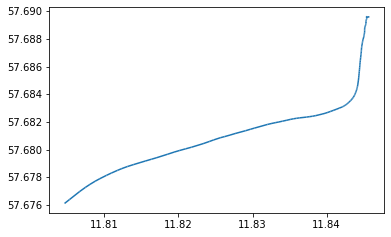

In [12]:
trajectory.plot()

This kind of individual trajectory is not very informative as such. We can add more context to our visualization by adding a background map and making it interactive. Movingpandas provides an easy-to-use api to plot the trajectory on top of OSM basemap with Holoviews/Bokeh:

In [13]:
trajectory.hvplot(frame_height=600, frame_width=800, line_width=3, line_color="red")

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]

This map provides much more contextual information and makes it possible to understand that the trajectory is a ship which is approaching or leaving the harbor of Gothenburg (tricky to say at this point). 

## Exploratory analysis with Space Time Cube (STC)

It is also fairly easy to visualize our trajectory in 3D using space time cube, in which the 3rd dimension is based on time. There are different libraries that can be used for plotting data in 3D, but we will use here [plotly](https://plotly.com/python/plotly-express/) library which provides a relatively easy and straightforward API to generate 3D visualizations. For plotting data in 3D Let's first modify our datetime information a bit, and only keep the time because all of our values are from the same date (5th of July, 2017): 

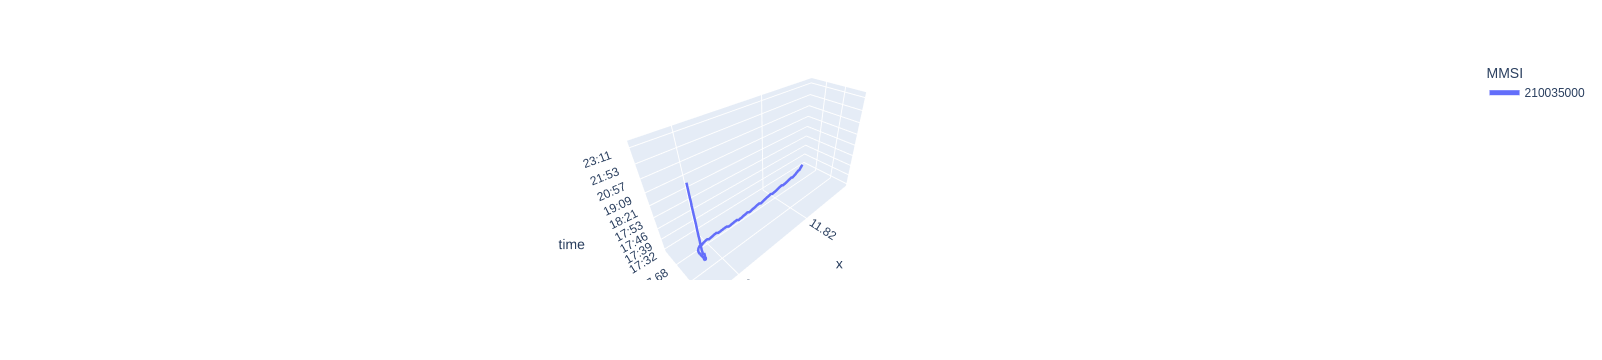

In [14]:
# Extract the time component
trajectory.df["time"] = pd.to_datetime(trajectory.df["Timestamp"]).dt.strftime("%H:%M")

# Plot the trajectory in space-time cube
fig = px.line_3d(trajectory.df, x="x", y="y", z="time", color='MMSI')
fig.update_traces(line=dict(width=5))

# Want to get background map as well? It is possible:
# https://chart-studio.plotly.com/~empet/14397/plotly-plot-of-a-map-from-data-available/#/

fig.show()

Great, now we can see our trajectory in 3D! Based on this viusalization we can already understand our data a bit better. We can for example, see how the ship has slowly approached the harbor and then docked around 18:00 when the movement has stopped (i.e. x/y coordinates do not change anymore). In a similar manner, we can process all our trajectories and plot them all together: 

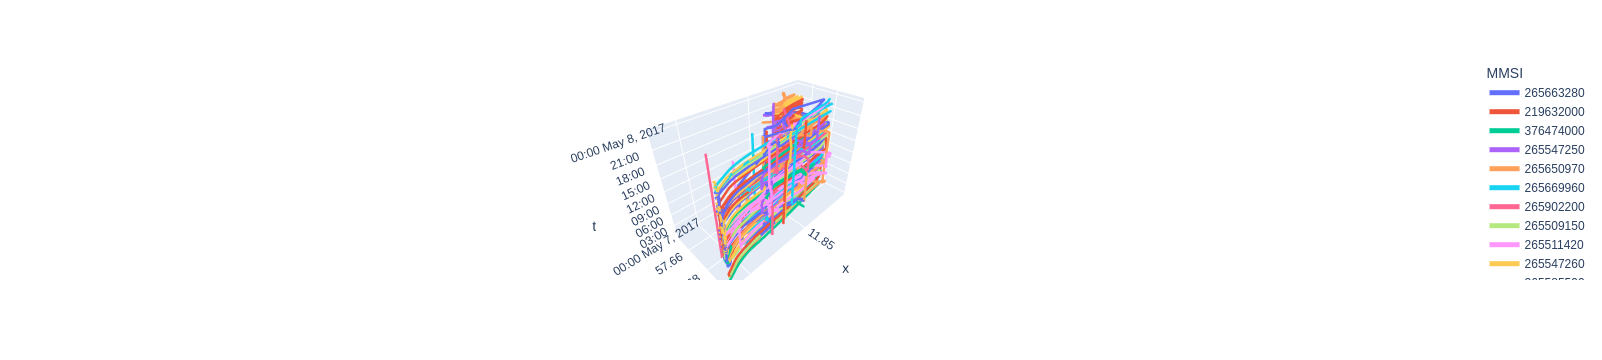

In [15]:
trajectories = gpd.GeoDataFrame()

i = 0
for trajectory in collection.trajectories:
    # Calculate speed
    trajectory.add_speed(overwrite=True)
    
    # Determine direction of movement
    trajectory.add_direction(overwrite=True)
    
    # Parse time component (as datetime)
    trajectory.df["t"] = pd.to_datetime(trajectory.df["Timestamp"])
    
    # Add unique id for each trajectory
    trajectory.df["tid"] = i
    
    # Add to container
    trajectories = trajectories.append(trajectory.df)
    i+=1
    
# Reorder the data based on timestamp
trajectories = trajectories.sort_values(by="t").reset_index(drop=True)

# Plot them all (use trajectory id to separate trajectories)
fig = px.line_3d(trajectories, x="x", y="y", z="t", color='MMSI')
fig.update_traces(line=dict(width=5))

# Want to get background map as well? It is possible:
# https://chart-studio.plotly.com/~empet/14397/plotly-plot-of-a-map-from-data-available/#/

fig.show()

The 3D visualization of multiple trajectories can look a bit messy (a bit like spaghetty), but we can already identify some patterns from the spate-time data. Looking at how the trajectories cluster in the STC, it is evident that there is a lot of activity throughout the day. There are two clear clusters in the data which basically represent activity related to two harbors in the area (Gothenburgs harbor and Saltholmens Brygga). From the data you can see how ships and boats are steadily approaching the harbors using more or less the same routes (at different times). Looking at the data, we can also see that one ship stayed the whole day in the harbor without moving anywhere (vertical line without movement). 

## Aggregating trajectories

As we can saw from the previous examples, looking at the movement data in 3D using STC can provide interesting insights that can be tricky to understand otherwise. However, understanding and reading the information takes a bit of time and experience before you start to understand what is going on in the data. There are however more tricks that we can do, to abstract our data and make it easier to understand in 2D. Movingpandas provides a handy tool called `TrajectoryCollectionAggregator` ([see docs](https://movingpandas.readthedocs.io/en/master/trajectoryaggregator.html)) which can be used to aggregate the trajectories by **extracting clusters of significant trajectory points and computing flows between the clusters**. These significant points of trajectories include e.g. their start and end points, the points of significant turns, and the points of significant stops, i.e. pauses in the movement (Andrienko & Andrienko, 2011). Once the points have been detected, then they are grouped based on their spatial proximity and flows are generated between them. We can aggregate the movement data following this approach easily with movingpandas, by specifying minimum and maximum threshold distances between significant points and minimum duration (in seconds) required to detect a stop from the data:

In [16]:
# Aggregate trajectories
agg = mpd.TrajectoryCollectionAggregator(collection, min_distance=500, max_distance=2000, min_stop_duration=timedelta(minutes=10))

# Get flows and clusters
flows = agg.get_flows_gdf()
clusters = agg.get_clusters_gdf()

As a result, we get DataFrames having information about weight of the flows as well as the size of the cluster:

In [17]:
flows.head()

geometry  weight
0  LINESTRING (11.80737 57.67704, 11.82295 57.68606)      40
1  LINESTRING (11.82295 57.68606, 11.84298 57.68311)      41
2  LINESTRING (11.81434 57.65202, 11.83678 57.65951)      79
3  LINESTRING (11.83678 57.65951, 11.84298 57.68311)       9
4  LINESTRING (11.84298 57.68311, 11.87490 57.68653)      47

In [18]:
clusters.head()

geometry    n
0  POINT (11.80737 57.67704)  104
1  POINT (11.84298 57.68311)  169
2  POINT (11.81434 57.65202)  131
3  POINT (11.87490 57.68653)  167
4  POINT (11.91230 57.69633)    0

Based on this information, we can create an interactive map that provides more easily understandable view for our spatio-temporal movement data:

In [19]:
# Plot with Holoviews
( flows.hvplot(title='Generalized aggregated trajectories', geo=True, hover_cols=['weight'], line_width='weight', alpha=0.5, color='#1f77b3', tiles='OSM', frame_height=400, frame_width=400) * 
  clusters.hvplot(geo=True, color='red', size='n') )

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (weight)
   .Points.I :Points   [Longitude,Latitude]   (n)

Great! As a result, we have a map which is quite easy to interpret with width of the line representing the volume of vessels moving between specific locations. We were able to get a sense of these patterns by looking at the movement data in 3D (i.e. where lot's of movement happens), but following this aggregation approach and visualizing the movement flows makes it much easier to get a grasp of the data. 

## Animating and exploring the trajectory characteristics in 3D 

The previous approaches have provided useful ways to extract information from movement data. Next, we will see how we can extract further characteristics based on the data using a WebGL based interactive visualization tool developed by Uber: [Kepler.gl](https://kepler.gl/).

Let's first manipulate our movement data a bit so that we can visualize it easily in 3D using Kepler.gl. Basically, what we want to do is to generate line segments between all observations in our data and convert them into Polygons by making a small buffer around them. This trick is needed to be able to take advantage of the full 3D capabilities of Kepler.gl. Let's start by preparing a couple of helper functions that generates the segments and converts them into a Polygon:

In [20]:
from shapely.geometry import LineString

def to_linestring(row):
    if row["end_geometry"] is not None:
        return LineString([row["geometry"], row["end_geometry"]])

def prepare_segments(trajectory):
    # Calculate segments for a single trajectory
    df = trajectory.df.join((trajectory.df["geometry"].shift(-1).to_frame().rename(columns={'geometry': 'end_geometry'})))

    # Create linestring
    df["segment"] = df[["geometry", "end_geometry"]].apply(to_linestring, axis=1)

    # Update geometry column with segments
    df["geometry"] = df["segment"]

    # Drop empty geoms (there is one after converting from points to lines)
    df = df.dropna(subset=["geometry"])

    # Drop unnecessary columns
    df = df.drop(["segment", "end_geometry"], axis=1)

    # Convert lines to polygons, so that volume/height can be adjusted
    df["geometry"] = df.buffer(0.0002)
    return df

In [41]:
movements = gpd.GeoDataFrame()

for trajectory in collection.trajectories:
    
    # Parse direction of movement using movingpandas function
    trajectory.add_direction(overwrite=True)

    # Parse speed using movingpandas function
    trajectory.add_speed(overwrite=True)

    # Create segments and calculate some useful statistics
    segments = prepare_segments(trajectory)
    movements = movements.append(segments)
    
    # Increase index
    i+=1
    
# Reset index
movements = movements.reset_index(drop=True)

# Drop "time" column which is in datetime format (Kepler.gl don't like it when saving the output)
movements = movements.drop(["time"], axis=1)

# Convert speed values to integer (to avoid issues with KeplerGl height)
movements["speed"] = movements["speed"].round(0).astype(int)

# What did we get?
movements.head()

Timestamp       MMSI               NavStatus  SOG   COG  \
0  05/07/2017 17:32:18  210035000  Under way using engine  9.8  52.8   
1  05/07/2017 17:32:28  210035000  Under way using engine  9.8  51.0   
2  05/07/2017 17:32:36  210035000  Under way using engine  9.8  51.0   
3  05/07/2017 17:32:38  210035000  Under way using engine  9.8  51.0   
4  05/07/2017 17:32:48  210035000  Under way using engine  9.7  52.0   

             Name ShipType                                           geometry  \
0  NORDIC HAMBURG    Cargo  POLYGON ((11.80521 57.67659, 11.80522 57.67660...   
1  NORDIC HAMBURG    Cargo  POLYGON ((11.80548 57.67641, 11.80548 57.67639...   
2  NORDIC HAMBURG    Cargo  POLYGON ((11.80548 57.67641, 11.80548 57.67639...   
3  NORDIC HAMBURG    Cargo  POLYGON ((11.80660 57.67718, 11.80662 57.67718...   
4  NORDIC HAMBURG    Cargo  POLYGON ((11.80735 57.67746, 11.80736 57.67747...   

           x          y  speed  direction  tid  
0  11.804620  57.676125      5  51.697066    0  
1  11.805283  57.676405      5  51.697066    0  
2  11.805283  57.676405      0   0.000000    0  
3  11.805283  57.676405      0   0.000000    0  
4  11.806675  57.676992     11  51.737848    0

Okay, now we have prepared our data and we can visualize it with Kepler.gl. What we will do next is to:

1. Determine the attribute which is used for coloring the trajectories (name)
2. Add a filter based on timestamp
3. Animate the movements with a selected time window
4. Determine that the height of data is based on the speed so that we can easily see areas and segments where the ships/boats have been moving fast

Notice, that these will be done using the graphical interface of Kepler.gl, hence, you need to check the video to understand how to repeat the steps. Initializing the Kepler.gl and adding our movement data to it is easy:

In [47]:
# Select a few sample trajectories for demonstration purposes
selected = movements.loc[movements["tid"]< 20].copy()

# Select only needed columns
selected = selected[["Timestamp", "Name", "geometry", "speed"]]

In [48]:
# Create a basemap 
m = KeplerGl(height=800, width=800)

# Add the movement data
m.add_data(selected, "trajectories")

# Render the map / interface
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'trajectories': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Once, we have prepared our visualization in a way how we want it, we can easily save our map into a dedicated html website with the current state of the page by:

In [24]:
m.save_to_html(file_name='Trajectories_3D.html')

Map saved to Trajectories_3D.html!
